In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from statistics import median

In [2]:
issue_dates = pd.read_csv("creation_dates.txt", names=["dates"], parse_dates=["dates"], infer_datetime_format=True)

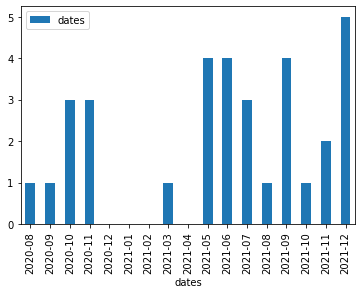

In [3]:
df = issue_dates.groupby([issue_dates["dates"].dt.to_period('M')]).count().resample('M').sum().fillna(0)
df.plot.bar()
plt.show()

In [4]:
menus = []
with open("menus.json") as f:
    for line in f:
        menus.append(' '.join(json.loads(line)["menu_items_1"]))
print("Example menu:\n\n" + menus[0])

Example menu:

en-oob en-sample en-test_zim en-test_mod en-map_admin en-osm_viewer_v2 en-usb en-kalite en-raspberrypi_stackexchange_com_en_all en-wikiquote_en_all_nopic en-wiktionary_en_all_nopic en-wikipedia_en_all_nopic en-musictheory en-olpc en-asst_medical en-math_expression en-rpi_guide en-peacebuilding en-understanding_algebra en-scratch en-wikem en-ebooks en-practical_action en-siyavula en-algebra2go en-boundless en-credits


# Dealing with Language

Our ultimate goal is to recommend groups of related modules to users who will be interested in them. In the short term, however, we just want to identify as many of these groups as we might be able to: we don't have a lot of data, so we won't be able to go very far. First, we'll investigate what languages we can plausibly make groups for. In the long term, we might hope to implicitly discover which languages go well together and match which users just from module- and user-level information, but since we have a small sample, we'll avoid making "We Look Stupid" mistakes by using a rule. We make use of the fact that each module's language is encoded with the two-letter [ISO 639-1 code](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes) and prepended to the module name:

In [5]:
def count_languages(menu):
    language_dict = {}
    for module in menu:
        language = module[:2]
        if language in language_dict:
            language_dict[language] += 1
        else:
            language_dict[language] = 1
    return language_dict

language_dicts = [count_languages(menu.split(' ')) for menu in menus]
print(language_dicts)

[{'en': 27}, {'en': 20}, {'en': 13}, {'en': 39}, {'es': 25, 'en': 4}, {'en': 39}, {'en': 17}, {'en': 20}, {'en': 14}, {'en': 15}, {'en': 21}, {'en': 11}, {'es': 25, 'en': 4}, {'fr': 21, 'en': 1}, {'en': 14}, {'en': 9}, {'en': 133}, {'en': 133}, {'en': 16}, {'es': 25, 'en': 4}, {'en': 19}, {'en': 10}]


A quick scan of the module groups that we downloaded reveals that most of the users have chosen English modules, with a small handful choosing French and Spanish. These users have a few English modules each, but not a significant amount and the ones they do have are probably just defaults. Thus, for now, we'll just look at the menus that are majority-English.

In [6]:
def find_majority_language(menu):
    language_dict = dict()
    for module in menu.split():
        language = module[:2]
        if language in language_dict:
            language_dict[language] += 1
        else:
            language_dict[language] = 1
    return max(language_dict, key=language_dict.get)

english_menus = []
for menu in menus:
    if find_majority_language(menu) == "en":
        english_menus.append(menu)
print("Found {} English menus".format(len(english_menus)))

Found 18 English menus


In [7]:
lengths = [len(menu) for menu in english_menus]
print("Average number of modules is {:.1f}".format(sum(lengths)/len(english_menus), '   '))
print("Median number of modules is {:.1f}".format(median(lengths)))

Average number of modules is 734.1
Median number of modules is 236.5


In [8]:
t = lambda x: x.split()
cts = CountVectorizer(tokenizer=t)
X = cts.fit_transform(english_menus)
Xc = (X.T * X)

/Users/cwivagg/opt/anaconda3/envs/iiab_v1/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


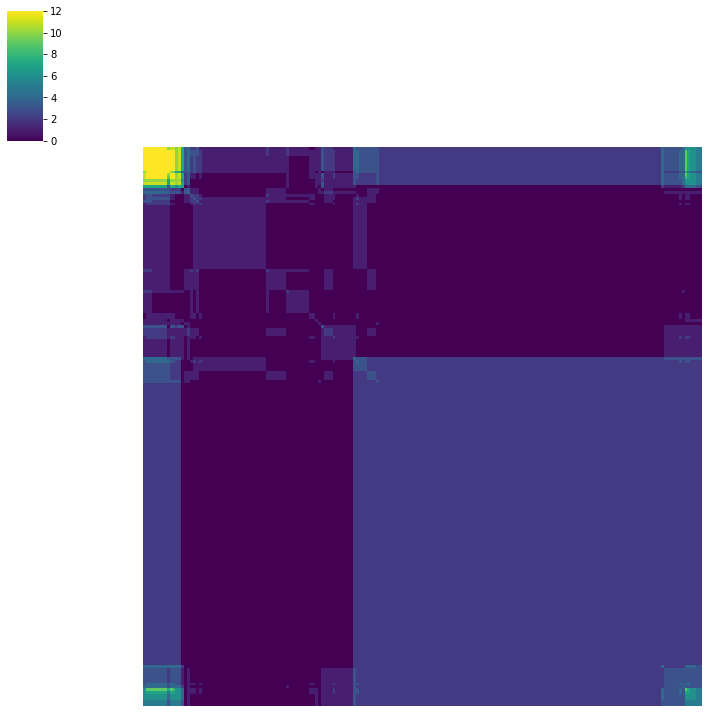

In [9]:
model = sns.clustermap(Xc.toarray(), cmap="viridis", vmax=12, xticklabels=False, yticklabels=False)
#cm = sns.heatmap(Xc.toarray()[model.dendrogram_row.reordered_ind][:,model.dendrogram_col.reordered_ind])
model.ax_row_dendrogram.set_visible(False)
model.ax_col_dendrogram.set_visible(False)
plt.show()